In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../')

In [3]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### CCM

In [8]:
%%time
pmpm_ccm_path = '../../../temp/pmpm_ccm.p'
ref_ccm_path = '../../../temp/ref_ccm.p'


pmpm_ccm = pd.read_pickle(pmpm_ccm_path)
ref_ccm = pd.read_pickle(ref_ccm_path)


CPU times: user 6.67 s, sys: 15.3 s, total: 22 s
Wall time: 1min 42s


In [7]:
pmpm_ccm.head()

PERS_ID    MEMBER_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_IP  ALLOW_SNF  ALLOW_OP  ALLOW_ER  ALLOW_RD  ALLOW_LAB  ALLOW_PATH  ALLOW_RX  ALLOW_UC  ALLOW_PCP  ALLOW_SPEC  ALLOW_OVMHSA  ALLOW_HHDM  DAYS_IP  DAYS_SNF  CC_HYPOTHYROID  CC_AMI  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_ANEMIA  CC_ASTHMA  CC_ATRIAL_FIB  CC_BPH  CC_CATARACT  CC_COPD  CC_DEPRESSION  CC_GLAUCOMA  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_OSTEOPOROSIS  CC_STROKE  CC_BREAST_CANCER  CC_COLORECTAL_CANCER  CC_PROSTATE_CANCER  CC_LUNG_CANCER  CC_ENDOMETRIAL_CANCER  CC_CHRONIC_KIDNEY  CC_DIABETES  CC_HEART_FAILURE  CC_ISCHEMIC  CC_ARTHRITIS  CC_AUTISM  CC_CEREBRAL_PALSY  CC_CYSTIC_FIBROSIS  CC_EPILEPSY  CC_INT_DISAB  CC_LEARN_DISAB  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_DEVELOP_DELAYS  CC_HEARING_IMPAIR  CC_VISUAL_IMPAIR  CC_SPINA_BIFIDA  CC_SPINAL_CORD  CC_TRAUMATIC_BRAIN  CC_ADHD  CC_ANXIETY_DISORDER  CC_BIPOLAR  CC_DEPRESSIVE_DISORDERS  CC_FIBROMYALGIA  \
0  2612620  CD124177500  201510        M            75.70       0.00       0.0        0.0       0.0       0.0       0.0       0.00         0.0      0.00      0.00        0.0        0.00           0.0         0.0      0.0       0.0               0       0             0                  0          0          0              0       0            0        0              0            0                0                  0                0                0          0                 0                     0                   0               0                      0                  0            0                 0            0             0          0                  0                   0            0             0               0                   0                      0                      0                  0                  0                 0                0               0                   0        0                    0           0                        0                0   
1  2613447  6A970852800  201510        M            75.54    2159.51       0.0        0.0       0.0       0.0      44.3      91.05         0.0    990.17    238.75        0.0      421.37           0.0        45.0      0.0       0.0               0       0             0                  0          0          0              1       1            1        0              0            0                0                  1                0                0          0                 0                     0                   0               0                      0                  0            1                 1            1             0          0                  0                   0            0             0               0                   0                      0                      0                  0                  0                 0                0               0                   0        0                    0           0                        0                0   
2  2613818  CD124453801  201510        M            75.46     176.44       0.0        0.0       0.0       0.0       0.0       0.00         0.0      0.00      0.00        0.0      176.44           0.0         0.0      0.0       0.0               0       0             0                  0          1          0              0       0            0        0              1            0                0                  1                1                0          0                 0                     0                   0               0                      0                  1            1                 0            0             0          0                  0                   0            0             0               0                   0                      0                      0                  0                  0                 0                0               0                   0        0                    0           0                        0                0   
3  2740429  5G934204100

In [9]:
pmpm_ccm.columns = [col.upper() for col in pmpm_ccm.columns]
pmpm_ccm.rename(columns = {'PERSON_ID':'PERS_ID'}, inplace = True)
#cols = [col for col in pmpm.columns if  col != 'MEDICAID_LOB']
#pmpm_ccm = pmpm_ccm[cols]

In [10]:
pmpm_ccm.head()

PERS_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  2612620  201510        M               75          0       0.0       0.0        0             0                  0       0          0                    0             0          0              0          0           0       0                 0            0                  0                  0                     0        0                   0              0                        0                  0            0                0          0                      0            0                0            0                  0                 0               0                     0                       0                     0                       0                           0               0               0                 0                0                  0                0               0             0            0               0             0         0               0            0                   0                      0                      0           0                0   
1  2613447  201510        M               75       2159       0.0       0.0        0             0                  0       0          0                    0             0          0              1          0           0       1                 0            1                  0                  0                     0        0                   0              0                        0                  0            1                0          7                      0            0                0            0                  0                 1               0                     0                       0                     0                       0                           0               0               0                 0                0                  1                0               0             0            1               0             0         0               0            0                   0                      0                      0           0                0   
2  2613818  201510        M               75        176       0.0       0.0        0             0                  0       0          1                    0             0          0              0          0           0       0                 0            0                  0                  1                     0        0                   0              1                        0                  0            1                0          7                      0            0                0            0                  0                 0               0                     0                       0                     0                       0                           0               0               0                 0                0                  1                1               0             0            0               0             0         0               0            0                   0                      0                      0           1                0   

In [11]:
ref_ccm.head()

PERS_ID   ref_id ref_create_date referral_date comanaged       principal_reason               reason_other referral_urgent          source_external source_external_other             source_internal source_internal_other   case_id       case_type  close_date           close_note close_outcome REGISTER_DATE
0  2563091  1471103      2014-02-12    2014-02-12       NaN  Other: please specify         see progress notes              No                      NaN                   NaN  AMCH Readmission Avoidance                   NaN   44500.0  MedCM Episodic  2014-02-13  case status changed         other    2014-02-12
1  2563337  2243272      2015-02-17    2015-02-17       NaN          Heart Failure  99y mbr discharged from a             NaN                      NaN                   NaN          Inpatient Programs                   NaN  401029.0  MedCM Episodic  2015-03-27  case status changed     goals met    2015-02-17
2  2563702  1929457      2014-10-22    2014-10-22        No  Other: please specify  see care web eps-00121560              No                      NaN                   NaN          Inpatient Programs                   NaN  375357.0  MedCM Episodic  2014-11-17  case status changed     goals met    2014-10-22
3  2563879  2034588      2014-12-16    2014-12-16        No   Coordination of Care                        NaN             Yes                      NaN                   NaN     Medical Case Management     Matrix assessment  388160.0  MedCM Episodic  2015-01-27  case status changed         other    2014-12-16
4  2563967  5519512      2019-11-21    2019-11-21       NaN  Other: please specify                        NaN              No  Member Family/Caregiver                   NaN                         NaN                   NaN       NaN             NaN         NaN                  NaN           NaN    2019-11-21

In [12]:
ref_ccm.principal_reason.value_counts()

Other: please specify                                                                     10181
Behavioral Health Other (Specify under Additional Information)                             8440
Coordination of Care                                                                       5296
High Risk Pregnancy                                                                        4139
Diabetes                                                                                   2950
Mental Health Condition (Specify under Additional Information)                             1424
Oncology                                                                                   1025
Hypertension                                                                                889
Substance Use Condition (Specify under Additional Information)                              824
COPD                                                                                        768
Psychosocial Concerns                   

In [13]:
pmpm_ccm.MYR = pmpm_ccm.MYR.astype(int)
pmpm_ccm.PERS_ID = pmpm_ccm.PERS_ID.astype(str)
pmpm_ccm.AGE_AT_MIDMONTH = pmpm_ccm.AGE_AT_MIDMONTH.astype(int)
pmpm_ccm.ALLOW_AMT = pmpm_ccm.ALLOW_AMT.astype(int)

In [14]:
pmpm_ccm = pmpm_ccm.drop_duplicates(subset = ['PERS_ID', 'MYR']).reset_index(drop = True)

In [18]:
pmpm_ccm.shape, ref_ccm.shape

In [17]:
ref_ccm = ref_ccm[~ref_ccm.ref_create_date.isin(['Member (Self Referral)'])].reset_index(drop = True)
ref_ccm['REGISTER_DATE'] = pd.to_datetime(ref_ccm['ref_create_date'], format = '%Y-%m-%d')
ref_ccm.rename(columns = {'person_id':'PERS_ID'}, inplace = True)
ref_ccm.sort_values(by = ['PERS_ID', 'REGISTER_DATE'], inplace = True)
ref_ccm.dropna(axis = 0, subset = ['PERS_ID', 'REGISTER_DATE'], inplace = True)
ref_ccm2 = ref_ccm.groupby(by = 'PERS_ID').apply(lambda x: x.iloc[0]).reset_index(drop = True)

In [19]:
ref_ccm2

PERS_ID   ref_id ref_create_date referral_date comanaged                                   principal_reason               reason_other referral_urgent          source_external source_external_other             source_internal source_internal_other   case_id       case_type  close_date           close_note close_outcome REGISTER_DATE
0      2563091  1471103      2014-02-12    2014-02-12       NaN                              Other: please specify         see progress notes              No                      NaN                   NaN  AMCH Readmission Avoidance                   NaN   44500.0  MedCM Episodic  2014-02-13  case status changed         other    2014-02-12
1      2563337  2243272      2015-02-17    2015-02-17       NaN                                      Heart Failure  99y mbr discharged from a             NaN                      NaN                   NaN          Inpatient Programs                   NaN  401029.0  MedCM Episodic  2015-03-27  case status changed     goals met    2015-02-17
2      2563702  1929457      2014-10-22    2014-10-22        No                              Other: please specify  see care web eps-00121560              No                      NaN                   NaN          Inpatient Programs                   NaN  375357.0  MedCM Episodic  2014-11-17  case status changed     goals met    2014-10-22
3      2563879  2034588      2014-12-16    2014-12-16        No                               Coordination of Care                        NaN             Yes                      NaN                   NaN     Medical Case Management     Matrix assessment  388160.0  MedCM Episodic  2015-01-27  case status changed         other    2014-12-16
4      2563967  5519512      2019-11-21    2019-11-21       NaN                              Other: please specify                        NaN              No  Member Family/Caregiver                   NaN                         NaN                   NaN       NaN             NaN         NaN                  NaN           NaN    2019-11-21
...        ...      ...             ...           ...       ...                                                ...                        ...             ...                      ...                   ...                         ...                   ...       ...             ...         ...                  ...           ...           ...
42045  5039937  5851916      2020-06-23    2020-06-16       NaN                                                NaN                        NaN             NaN                      NaN                   NaN          Inpatient Programs                   NaN       NaN             NaN         NaN                  NaN           NaN    2020-06-23
42046  5040810  5876404      2020-07-13    2020-07-13       NaN  Substance Use Condition (Specify under Additio...                        NaN             Yes                      NaN                   NaN           Behavioral Health                   NaN       NaN             NaN         NaN                  NaN           NaN    2020-07-13
42047  5041042  5878274      2020-07-14    2020-07-14        No  Mental Health Condition (Specify under Additio...                        NaN              No                      NaN                   NaN           Behavioral Health                   NaN       NaN             NaN         NaN                  NaN           NaN    2020-07-14
42048  5041108  5869376      2020-07-07    2020-07-07       NaN                              Other: please specify   John is new to Medicaid.              No                      NaN                   NaN     Medical Case Management                   NaN       NaN             NaN         NaN                  NaN           NaN    2020-07-07
42049  5042185  5879605      2020-07-15    2020-07-15       NaN                              Other: please specify  Christina from MS LM on t              No                      NaN                   NaN             Member Services             

In [12]:
#pmpm_ccm.to_pickle('../../../temp/pmpm_ccm.p')
#ref_ccm.to_pickle('../../../temp/ref_ccm.p')

## KMF Curves Survival

In [20]:
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time

In [21]:
#select columns from ref
ref_ccm_select = ref_ccm2[['PERS_ID', 'REGISTER_DATE', 'principal_reason']]

In [22]:
#convert register date to MYR
ref_ccm_select['REGISTER_DATE'] = ref_ccm_select['REGISTER_DATE'].dt.strftime('%Y%m').astype('int')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
ref_ccm_select

PERS_ID  REGISTER_DATE                                   principal_reason
0      2563091         201402                              Other: please specify
1      2563337         201502                                      Heart Failure
2      2563702         201410                              Other: please specify
3      2563879         201412                               Coordination of Care
4      2563967         201911                              Other: please specify
...        ...            ...                                                ...
42045  5039937         202006                                                NaN
42046  5040810         202007  Substance Use Condition (Specify under Additio...
42047  5041042         202007  Mental Health Condition (Specify under Additio...
42048  5041108         202007                              Other: please specify
42049  5042185         202007                              Other: please specify

[42050 rows x 3 columns]

In [25]:
#join these two tables on person id
merged = pmpm_ccm.join(ref_ccm_select.set_index('PERS_ID'), on='PERS_ID', how='inner')

In [27]:
merged.PERS_ID.unique().shape

In [28]:
#sort values and rearrange columns
merged = merged.sort_values(by=['PERS_ID', 'MYR', 'REGISTER_DATE'])[['PERS_ID', 'MYR', 'REGISTER_DATE', 'principal_reason', 'ALLOW_IP', 'ALLOW_ER']]

In [29]:
#create acute care binary event
merged['ACUTE_BIN'] = ((merged.ALLOW_IP>0) | (merged.ALLOW_ER>0)).astype(int)

In [32]:
#check how many samples in pmpm are after their referral date
(merged['MYR']>=merged['REGISTER_DATE']).astype(int).sum()

1086528

In [33]:
#only rows where data is equal or later than register date for referral
merged = merged[merged.MYR>=merged.REGISTER_DATE]

In [34]:
from datetime import datetime

#change the date formats to datetimes for calculating difference in month
merged['reg'] = merged.REGISTER_DATE.astype('str').apply(lambda x: datetime.strptime(x, '%Y%m'))
merged['myr'] = merged.MYR.astype('str').apply(lambda x: datetime.strptime(x, '%Y%m'))

In [37]:
#difference between pmpm record date and first ref date (in months)
merged['duration'] = np.round(((merged['myr'] - merged['reg'])/np.timedelta64(1, 'M'))).astype(int)

In [38]:
merged

PERS_ID     MYR  REGISTER_DATE                                   principal_reason  ALLOW_IP  ALLOW_ER  ACUTE_BIN        reg        myr  duration
1989959   2563702  201510         201410                              Other: please specify      0.00       0.0          0 2014-10-01 2015-10-01        12
1969018   2563702  201511         201410                              Other: please specify      0.00       0.0          0 2014-10-01 2015-11-01        13
21411843  2563702  201512         201410                              Other: please specify      0.00       0.0          0 2014-10-01 2015-12-01        14
2088060   2563702  201601         201410                              Other: please specify      0.00       0.0          0 2014-10-01 2016-01-01        15
1958395   2563702  201602         201410                              Other: please specify   5466.53       0.0          1 2014-10-01 2016-02-01        16
...           ...     ...            ...                                                ...       ...       ...        ...        ...        ...       ...
22295937  5039414  202006         202006  Substance Use Condition (Specify under Additio...      0.00       0.0          0 2020-06-01 2020-06-01         0
17413722  5039437  202006         202006  Mental Health Condition (Specify under Additio...      0.00       0.0          0 2020-06-01 2020-06-01         0
19343809  5039442  202006         202006                               Coordination of Care      0.00       0.0          0 2020-06-01 2020-06-01         0
20764273  5039723  202006         202006                              Other: please specify   5120.52       0.0          1 2020-06-01 2020-06-01         0
18020749  5039937  202006         202006                                                NaN  11608.48       0.0          1 2020-06-01 2020-06-01         0

[1086528 rows x 10 columns]

In [40]:
#drop nans in reason code
merged.dropna(axis = 0, subset = ['PERS_ID', 'REGISTER_DATE', 'principal_reason'], inplace = True)

In [41]:
merged

PERS_ID     MYR  REGISTER_DATE                                   principal_reason  ALLOW_IP  ALLOW_ER  ACUTE_BIN        reg        myr  duration
1989959   2563702  201510         201410                              Other: please specify      0.00      0.00          0 2014-10-01 2015-10-01        12
1969018   2563702  201511         201410                              Other: please specify      0.00      0.00          0 2014-10-01 2015-11-01        13
21411843  2563702  201512         201410                              Other: please specify      0.00      0.00          0 2014-10-01 2015-12-01        14
2088060   2563702  201601         201410                              Other: please specify      0.00      0.00          0 2014-10-01 2016-01-01        15
1958395   2563702  201602         201410                              Other: please specify   5466.53      0.00          1 2014-10-01 2016-02-01        16
...           ...     ...            ...                                                ...       ...       ...        ...        ...        ...       ...
18077138  5039054  202005         202005                               Coordination of Care   8394.62   1738.87          1 2020-05-01 2020-05-01         0
22295937  5039414  202006         202006  Substance Use Condition (Specify under Additio...      0.00      0.00          0 2020-06-01 2020-06-01         0
17413722  5039437  202006         202006  Mental Health Condition (Specify under Additio...      0.00      0.00          0 2020-06-01 2020-06-01         0
19343809  5039442  202006         202006                               Coordination of Care      0.00      0.00          0 2020-06-01 2020-06-01         0
20764273  5039723  202006         202006                              Other: please specify   5120.52      0.00          1 2020-06-01 2020-06-01         0

[1044686 rows x 10 columns]

In [42]:
#convert the reason codes into list
reason_codes = (merged.principal_reason.value_counts()).index.values.tolist()

In [43]:
#window considered for survival curves
merged = merged[(merged.MYR>=201701) & (merged.MYR<=202006)]

In [44]:
merged.duration.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 10, 11, 12, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,  8,  9,
       13, 69, 70, 71, 72, 73, 74, 75, 76, 77])

## Survival Curves

In [52]:
merged.PERS_ID.unique().shape

In [47]:
merged = merged.sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

In [50]:
survTr = merged.copy().groupby('PERS_ID').apply(survival_diabetes,onset = 'ACUTE_BIN', after = 0).reset_index(drop = True)


In [55]:
merged[merged.PERS_ID == "2563967"]['ACUTE_BIN']

0    0
1    0
2    0
3    0
4    1
5    0
6    0
7    0
Name: ACUTE_BIN, dtype: int64

In [53]:
survTr.head()

PERS_ID   T  E  ALLOW_ER  ALLOW_IP     MYR  REGISTER_DATE  duration        myr       principal_reason        reg
0  2563967   5  1       0.0      0.00  201911         201911         0 2019-11-01  Other: please specify 2019-11-01
1  2564074  15  1       0.0      0.00  201701         201511        14 2017-01-01   Coordination of Care 2015-11-01
2  2564164   1  1       0.0   8966.59  201701         201701         0 2017-01-01  Other: please specify 2017-01-01
3  2564350   7  1       0.0      0.00  201701         201410        27 2017-01-01  Other: please specify 2014-10-01
4  2564378   3  0       0.0      0.00  201701         201603        10 2017-01-01  Other: please specify 2016-03-01

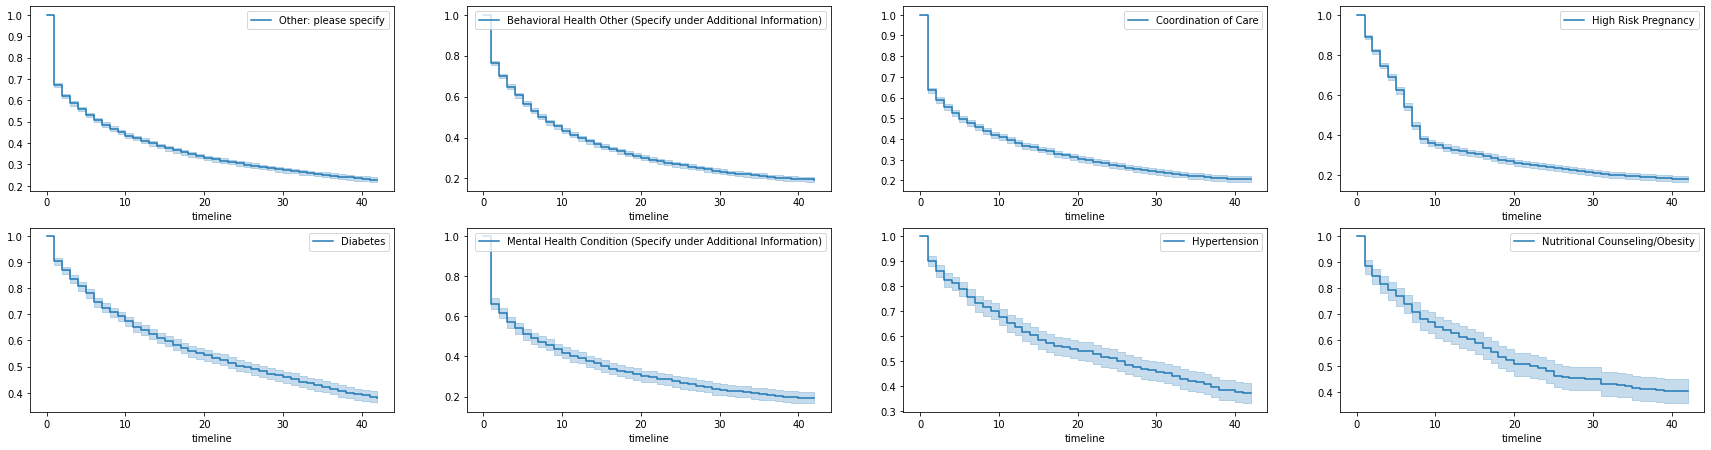

In [63]:
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (30,40)

for i, reason in enumerate(reason_codes[:8]):
    ax = plt.subplot(10, 4, i+1)
    
    kmf = KaplanMeierFitter()
    df = survTr[survTr.principal_reason==reason]
   # print(df.shape)
    
    T = df['T']
    E = df['E']
    
    kmf.fit(T, event_observed=E, label=reason)
    kmf.plot_survival_function(ax=ax, legend=True)

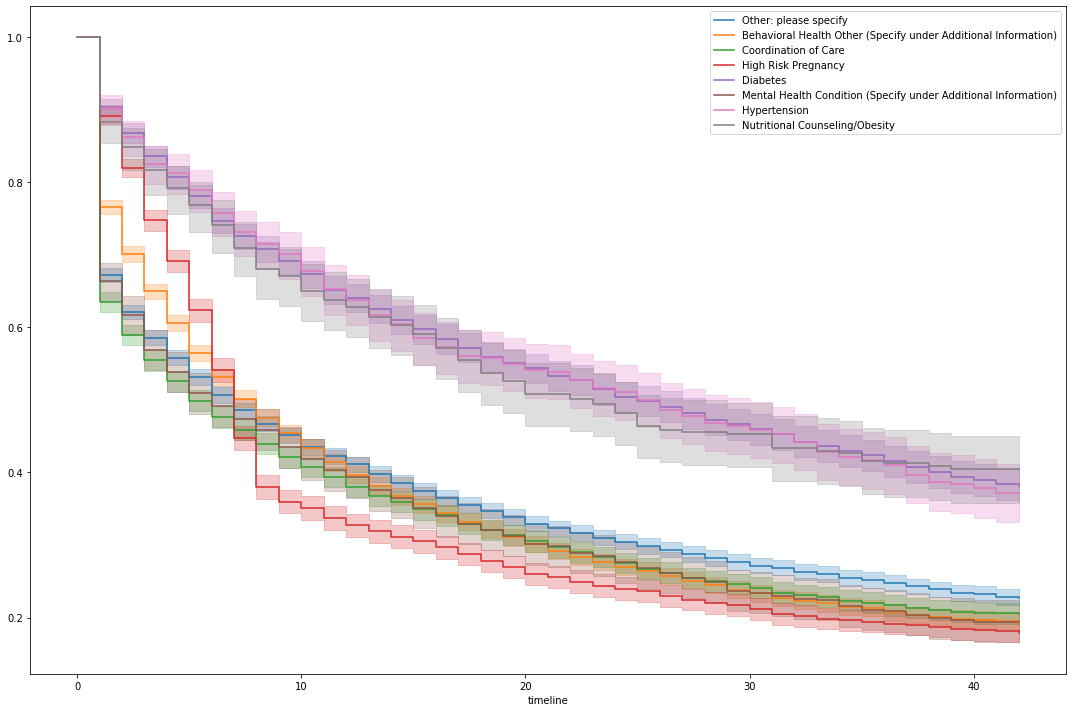

In [60]:
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

#top 8 most frequent reason codes' population survival curve after first referral: time to first acute care visit

for i, reason in enumerate(reason_codes[:8]):
    
    kmf = KaplanMeierFitter()
    df = survTr[survTr.principal_reason==reason]
    
    T = df['T']
    E = df['E']
    
    kmf.fit(T, event_observed=E, label=reason)
    kmf.plot_survival_function()
    plt.tight_layout()

<AxesSubplot:xlabel='timeline'>

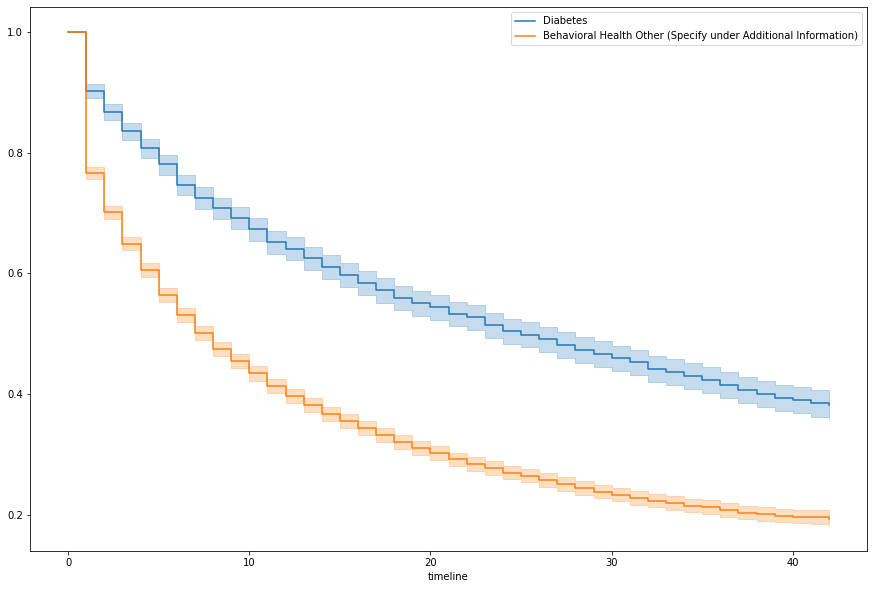

In [61]:
#two reason codes particular to compare

kmf = KaplanMeierFitter()
df = survTr[survTr.principal_reason=='Diabetes']
df2 = survTr[survTr.principal_reason=='Behavioral Health Other (Specify under Additional Information)']

T = df['T']
T2 = df2['T']
E = df['E']
E2 = df2['E']

kmf.fit(T, event_observed=E, label='Diabetes')
kmf.plot_survival_function()
kmf.fit(T2, event_observed=E2, label='Behavioral Health Other (Specify under Additional Information)')
kmf.plot_survival_function()

In [62]:
#logrank statistics
from lifelines.statistics import logrank_test

results = logrank_test(T, T2, E, E2, alpha=.05)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.05
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         456.78 <0.005    334.24